In [2]:
import numpy as np

import autograd.numpy as npa

import legume
legume.set_backend('autograd')

from legume.minimize import Minimize
from legume.primitives import fmap

from chickpea import PhotonicCrystalCavity
%load_ext autoreload
%autoreload 2

array([[4.8841, 4.8841, 4.8841, ..., 4.8841, 4.8841, 4.8841],
       [4.8841, 4.8841, 4.8841, ..., 4.8841, 4.8841, 4.8841],
       [4.8841, 4.8841, 4.8841, ..., 4.8841, 4.8841, 4.8841],
       ...,
       [4.8841, 4.8841, 4.8841, ..., 4.8841, 4.8841, 4.8841],
       [4.8841, 4.8841, 4.8841, ..., 4.8841, 4.8841, 4.8841],
       [4.8841, 4.8841, 4.8841, ..., 4.8841, 4.8841, 4.8841]])

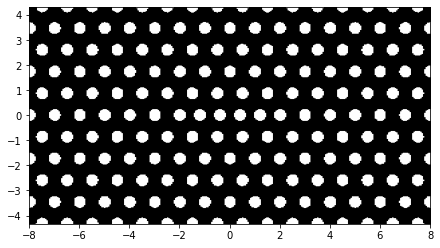

In [3]:
# Number of PhC periods in x and y directions
Nx, Ny = 16, 10
a=1
# Regular PhC parameters
ra = 0.234
dslab = 0.4355
n_slab = 2.21



# Initialize a lattice and PhC
lattice = legume.Lattice([Nx*a, 0], [0, Ny*np.sqrt(3)/2*a])

pcc = PhotonicCrystalCavity(crystal='L', n=3, m=4, thickness=dslab,
                            supercell_size=(Nx,Ny),
                            radius=ra, eps=n_slab**2)
phc=pcc.cavity()

legume.viz.eps_xy(phc, z=dslab/2, Nx=300, Ny=300)

In [4]:
nc = pcc.num_holes()

bounds=[-0.09, 0.09]

gmax = 3
pstart = np.zeros((2*nc, ))

options = {'gmode_inds': [0],
           'verbose': True, # No need to clutter the optimization output.
           'gradients': 'exact',
           'numeig': 1, # We only need target mode
           'eig_sigma': 0.42,  # We want mode closest to this frequency.
           'eig_solver': 'eigsh'
           }

In [5]:
def gme_cavity(dx, dy, gmax, options):
    # Initialize PhC
    phc = pcc.cavity(dx, dy)

    # For speed, we don't want to compute the loss rates of *all* modes that we store
    options['compute_im'] = False
    # Initialize GME
    gme = legume.GuidedModeExp(phc, gmax=gmax)

    # Solve for the real part of the frequencies
    gme.run(kpoints=np.array([[0], [0]]), **options)

    # Find the imaginary frequency of the fundamental cavity mode
    (freq_im, _, _) = gme.compute_rad(0,[0])

    # Finally, compute the quality factor
    Q = gme.freqs[0, 0]/2/freq_im[0]
    # eig = gme.eigvecs[0,0]
    # if eig.__class__ == np.ndarray:
    #     options['eig_start'] = eig


    return (gme, Q)

def of_Q(params):
    dx = params[0:nc]
    dy = params[nc:]
    (gme, Q) = gme_cavity(dx, dy, gmax=gmax, options=options)

    # We put a negative sign because we use in-built methods to *minimize* the objective function
    return -Q

In [6]:
opt_gme, Q = gme_cavity(pstart[0:nc], pstart[nc:], gmax, options)

21.4262s total time for real part of frequencies, of which
  0.6944s for guided modes computation using the gmode_compute='exact' method
  2.8581s for inverse matrix of Fourier-space permittivity
  2.2308s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


In [8]:
eig_start = opt_gme.eigvecs[0]
options = {'gmode_inds': [0],
           'verbose': True, # No need to clutter the optimization output.
           'gradients': 'exact',
           'numeig': 1, # We only need target mode
           'eig_sigma': 0.42,  # We want mode closest to this frequency.
           'eig_solver': 'eigsh',
           'eig_start': eig_start
           }

In [9]:
eig_start.shape

(4947, 1)

In [10]:
opt_gme.gvec.shape[0]

2

In [11]:
opt_gme_2, Q_2 = gme_cavity(pstart[0:nc], pstart[nc:], gmax, options)


1556.9853s total time for real part of frequencies, of which
  1.6120s for guided modes computation using the gmode_compute='exact' method
  2.5774s for inverse matrix of Fourier-space permittivity
  1537.2989s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


In [22]:
opt_gme.t_eig

9.341672897338867

In [23]:
opt_gme_2.t_eig

9.447638988494873

In [24]:
# # Print the computed quality factor
# print("Cavity quality factor: %1.2f" %Q)
#
# # We can also visualize the cavity and the mode profile of the fundamental mode
# ax = legume.viz.field(opt_gme, 'e', 0, 0, z=dslab/2, component='y', val='abs', N1=160, N2=100)

In [25]:
# opt = Minimize(of_Q)
#
#
# options["verbose"]=False
#
#
# # Run an 'adam' optimization
# (p_opt, ofs) = opt.adam(pstart, step_size=0.005, Nepochs=10, bounds = [-0.25, 0.25])
#
# # Optimized parameters
# dx = p_opt[0:nc]
# dy = p_opt[nc:]

In [26]:
# Run the simulation
# opt_gme, Q_opt = gme_cavity(p_opt[0:nc], p_opt[nc:], gmax, options)
